# Consumo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
import seaborn as sns
from datetime import datetime
from pandas_profiling import ProfileReport
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Análisis exploratorio

In [ ]:
dfConsumo = pd.read_excel('consumos.xlsx', sheet_name='CONS-MES T', index_col=None, skiprows=6, nrows=264, usecols='B:AB')
dfConsumo['Fecha'] = pd.to_datetime(dfConsumo['Fecha'])
dfConsumo['Anio'] = pd.DatetimeIndex(dfConsumo['Fecha']).year
dfConsumo.set_index('Fecha', inplace=True)
dfConsumo = dfConsumo[['Anio','Gasolina superior', 'Gasolina regular', 'Diesel']]
dfConsumo.rename(columns = {'Gasolina superior':'Super', 'Gasolina regular':'Regular'}, inplace = True)
dfGeneralConsumo = dfConsumo
superC = dfConsumo['Super']
regularC = dfConsumo['Regular']
dieselC = dfConsumo['Diesel']
dfConsumo

,Anio,Super,Regular,Diesel
Fecha,,,,
2000-01-01,2000,308156.82,202645.20,634667.06
2000-02-01,2000,307766.31,205530.96,642380.66
2000-03-01,2000,331910.29,229499.56,699807.25
2000-04-01,2000,315648.08,210680.40,586803.98
2000-05-01,2000,319667.97,208164.34,656948.20
...,...,...,...,...
2021-08-01,2021,636824.61,668221.54,1115150.47
2021-09-01,2021,605257.76,670418.80,1113234.30
2021-10-01,2021,675821.54,718676.32,1177906.10


In [ ]:
profile_importC = ProfileReport(dfConsumo, minimal = True, title="Reporte Consumo")
profile_importC

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Anio'>

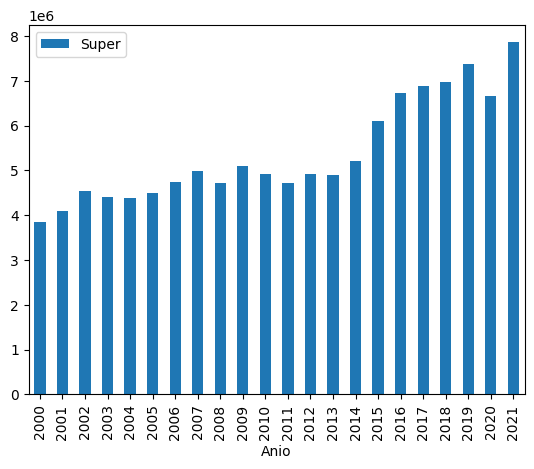

In [ ]:
dfConsumo[['Anio', 'Super']].groupby(['Anio']).sum().plot.bar()

<AxesSubplot:xlabel='Anio'>

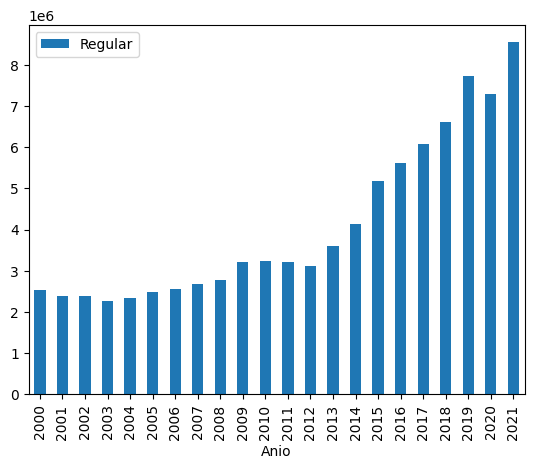

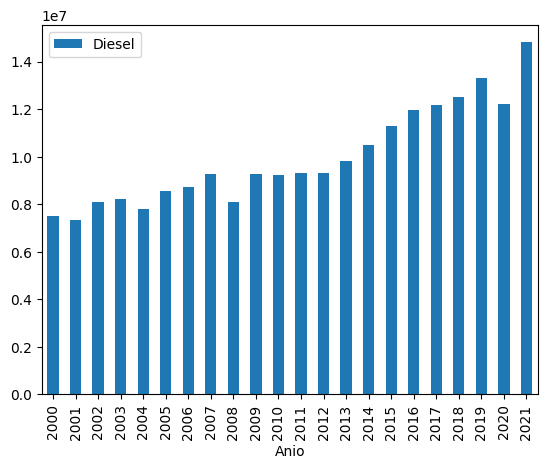

In [ ]:
dfConsumo[['Anio', 'Regular']].groupby(['Anio']).sum().plot.bar()
dfConsumo[['Anio', 'Diesel']].groupby(['Anio']).sum().plot.bar()

<AxesSubplot:xlabel='Diesel', ylabel='Count'>

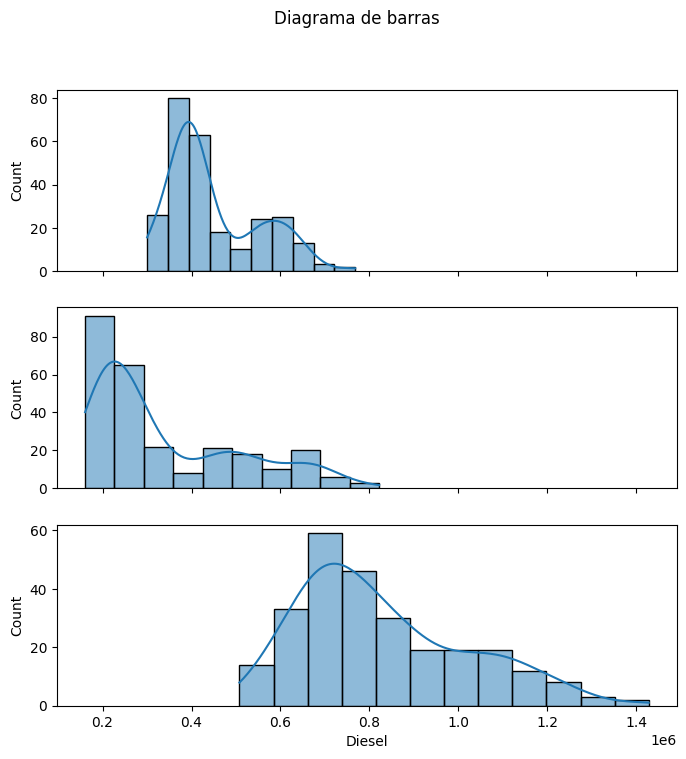

In [ ]:
fig, axes = plt.subplots(3, 1,sharex=True, figsize=(8, 8))
 
fig.suptitle('Diagrama de barras')
sns.histplot(ax=axes[0], data=dfConsumo, x="Super", kde=True)
sns.histplot(ax=axes[1], data=dfConsumo, x="Regular", kde=True)
sns.histplot(ax=axes[2], data=dfConsumo, x="Diesel", kde=True)

In [ ]:
#Consumo
print("El  máximo de consumo súper es {} y el mínimo es de {} ".format(dfConsumo.max()[1], dfConsumo.min()[1]))
print("El máximo de consumo regular es {} y el mínimo es de {} ".format(dfConsumo.max()[2], dfConsumo.min()[2]))
print("El máximo de consumo diesel es {} y el mínimo es de {} ".format(dfConsumo.max()[3], dfConsumo.min()[3]))

El  máximo de consumo súper es 768102.83 y el mínimo es de 300242.7816666665 
El máximo de consumo regular es 821882.15 y el mínimo es de 160741.9 
El máximo de consumo diesel es 1427888.03 y el mínimo es de 507662.65 


<AxesSubplot:xlabel='Fecha', ylabel='Diesel'>

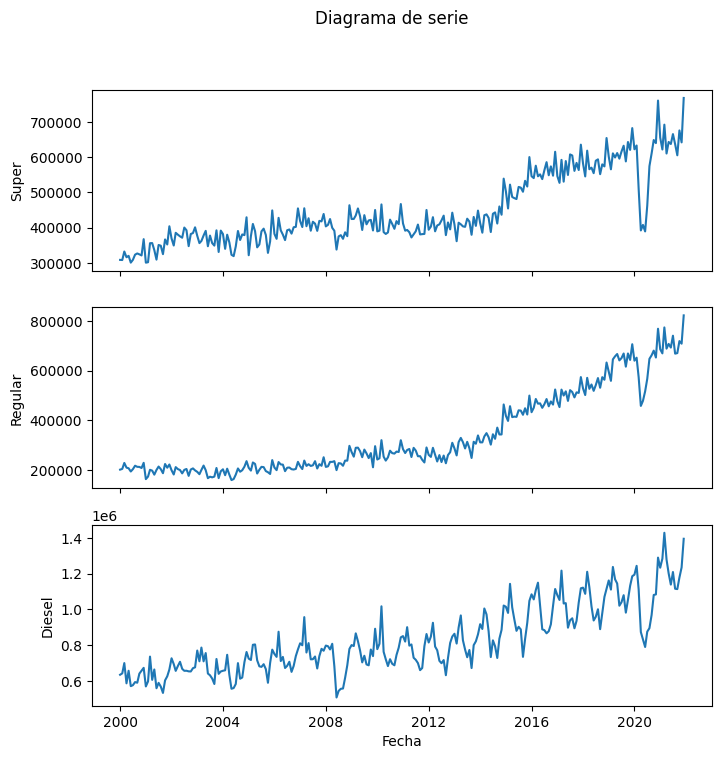

In [ ]:
fig, axes = plt.subplots(3, 1,sharex=True, figsize=(8, 8))
 
fig.suptitle('Diagrama de serie')
sns.lineplot(ax=axes[0], data=superC)
sns.lineplot(ax=axes[1], data=regularC)
sns.lineplot(ax=axes[2], data=dieselC)

## Series

In [ ]:
dfTestConsumo = dfConsumo[(dfConsumo['Anio'].isin([2021,2022]))]
dfConsumo = dfConsumo[dfConsumo.Anio != 2021]
dfConsumo= dfConsumo[dfConsumo.Anio != 2022]
superC = dfConsumo['Super']
regularC = dfConsumo['Regular']
dieselC = dfConsumo['Diesel']
dfTestConsumo

,Anio,Super,Regular,Diesel
Fecha,,,,
2021-01-01,2021,655512.66,685942.97,1232702.27
2021-02-01,2021,621712.09,669312.88,1283552.44
2021-03-01,2021,692240.49,773453.52,1427888.03
2021-04-01,2021,610310.75,688389.03,1278367.50
2021-05-01,2021,643076.84,707336.38,1200963.69
2021-06-01,2021,637332.81,692598.71,1138265.95
2021-07-01,2021,665472.94,740193.13,1208648.56
2021-08-01,2021,636824.61,668221.54,1115150.47
2021-09-01,2021,605257.76,670418.80,1113234.30


### Consumo Súper

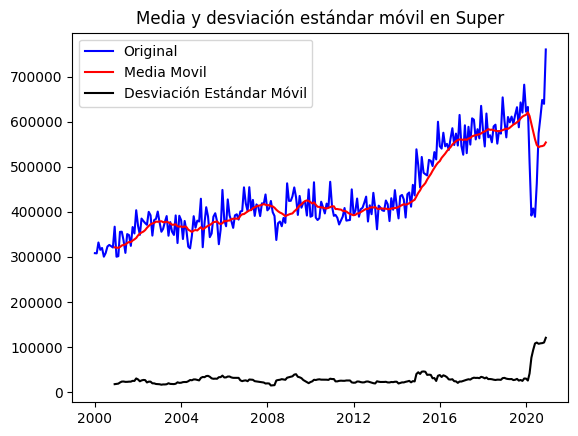

In [ ]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = superC.rolling(window=12).mean()
deMovil = superC.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(superC, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil en Super')
plt.rcParams["figure.figsize"] = (10,4)
plt.show(block=False)

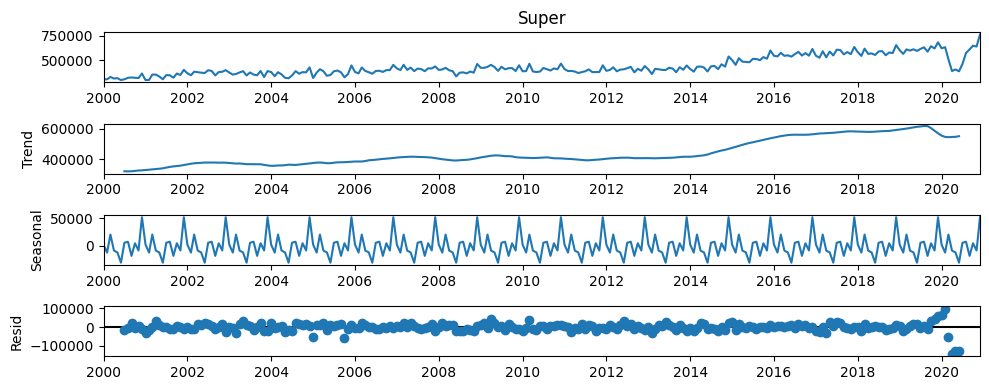

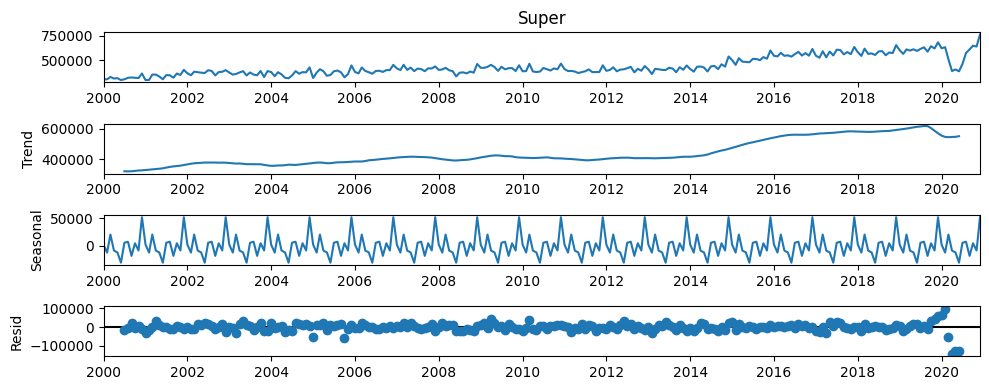

In [ ]:
descomposicion = seasonal_decompose(superC)
descomposicion.plot()

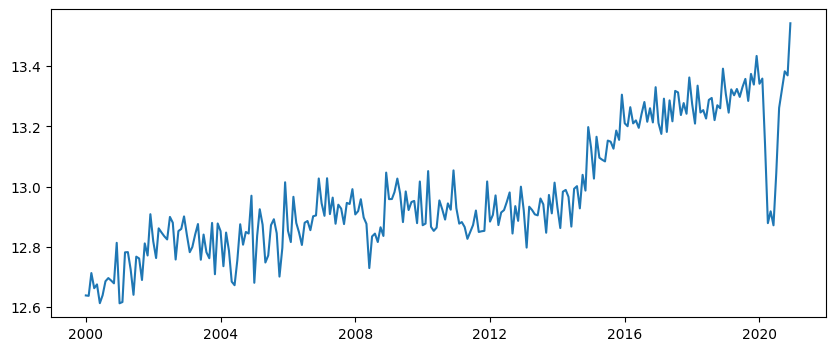

In [ ]:
SuperC_log = np.log(superC)
plt.plot(SuperC_log)

In [ ]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(superC, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.659446
p-value                        0.856976
# de retardos usados          12.000000
# de observaciones usadas    239.000000
Critical Value (1%)           -3.458011
Critical Value (5%)           -2.873710
Critical Value (10%)          -2.573256
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula en donde afirmamos que existen raices unitarias. La serie por lo tanto, no es estacionaria en media, a lo que se recurre una diferenciación

In [ ]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
superC_diff = superC.diff()
superC_diff.dropna(inplace=True)
dfTest = adfuller(superC_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -5.852312e+00
p-value                      3.565597e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    2.390000e+02
Critical Value (1%)         -3.458011e+00
Critical Value (5%)         -2.873710e+00
Critical Value (10%)        -2.573256e+00
dtype: float64


Se hace una diferenciación y ahí si queda.

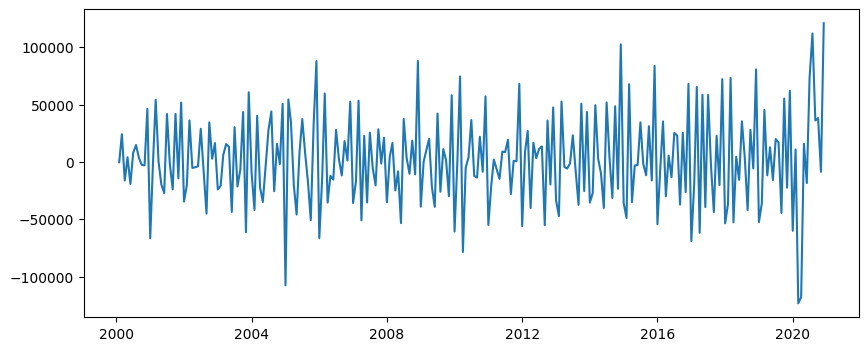

In [ ]:
plt.plot(superC_diff)

Se tuvo que aplicar una transformación logarítmica y una diferenciación. Podemos decir que la serie es estacionaria ahora en media y en varianza. Toca ahora estimar los parámetros del modelo.

In [ ]:
superClog_diff = SuperC_log.diff()
superClog_diff.dropna(inplace = True)
tsa_acf = acf(superClog_diff,nlags=5,fft=False)
tsa_pacf = pacf(superClog_diff, nlags=36)
tsa_acf

array([ 1.        , -0.36972789, -0.07165378,  0.07510063, -0.04722668,
        0.21437885])

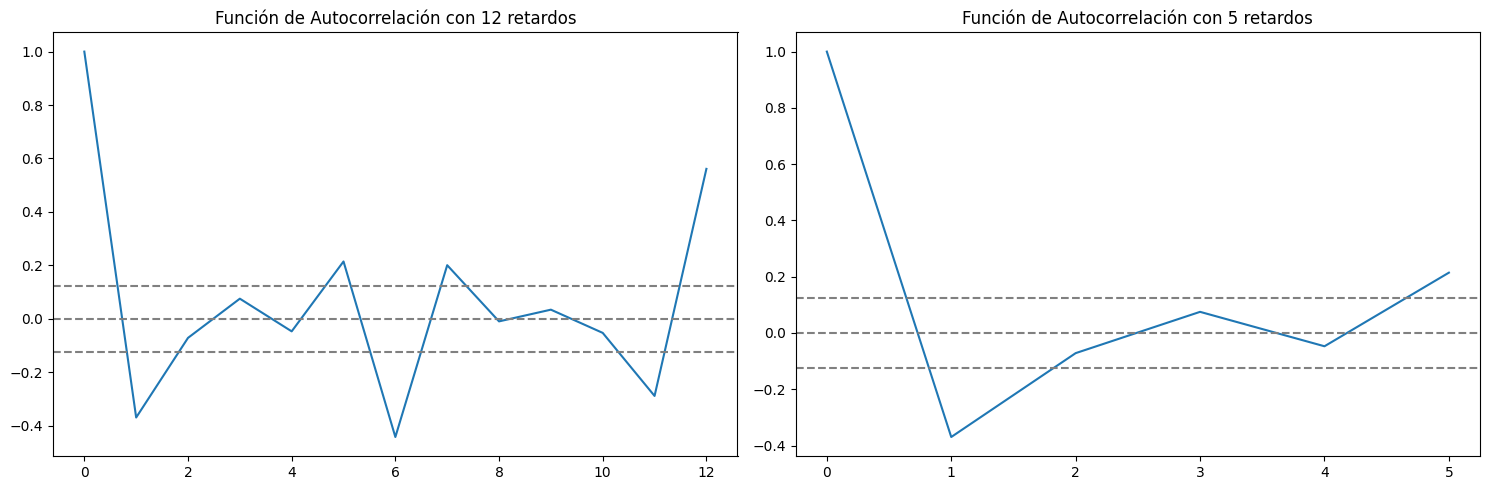

In [ ]:
#plot PAC
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(superClog_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(superClog_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

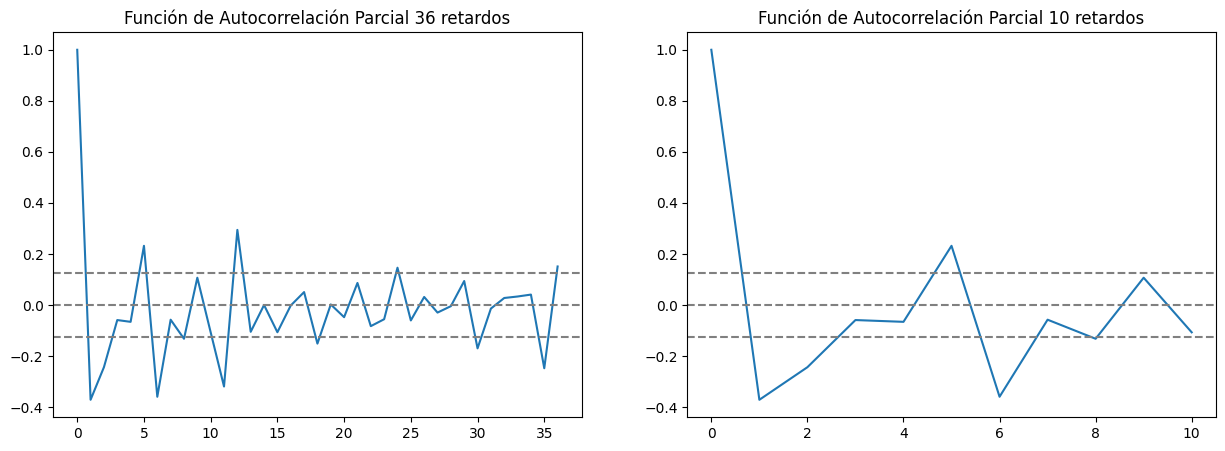

In [ ]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(superClog_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(superClog_diff, nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 10 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Con los gráficos dados, podemos observar que tenemos un valor p=12 q=6 & d=1. 

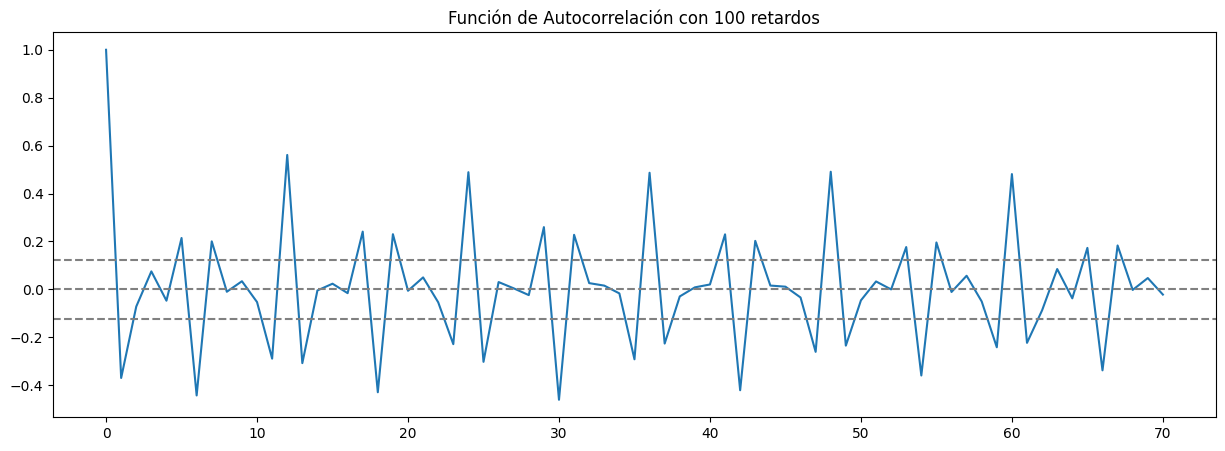

In [ ]:
plt.plot(acf(superClog_diff,nlags=70,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 100 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 

Como se puede observar el comportamiento es similar para 12, 24, 36,48,60 meses por lo que hay una correlación entre los años, eso indica que hay estacionalidad cada 12 meses. Deberíamos agregarle el componente estacional

In [ ]:
superC_log_D = SuperC_log.diff(31)
superC_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

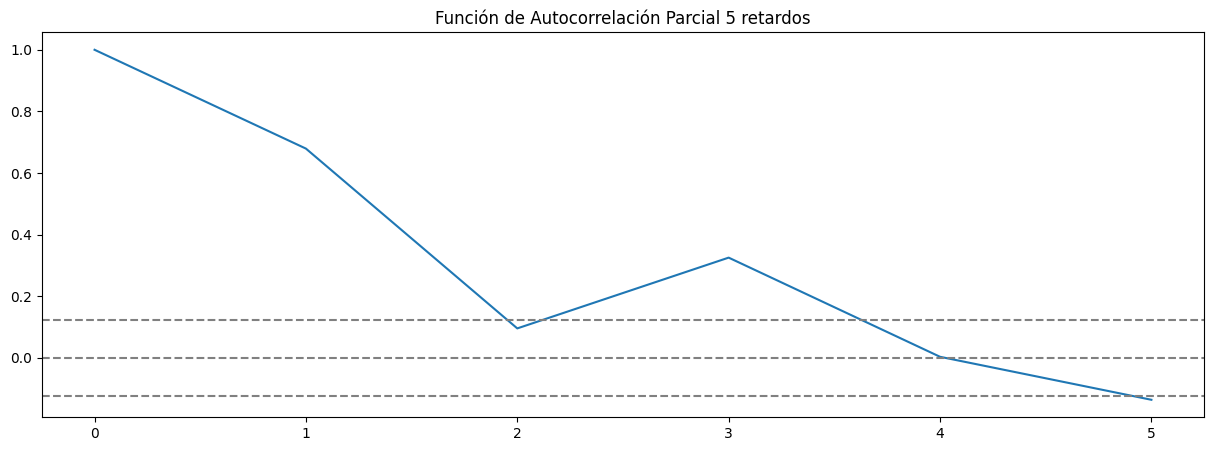

In [ ]:
plt.plot(pacf(superC_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(superClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

P = 3

In [ ]:
modelo11116 = SARIMAX(SuperC_log, order=(11,11,6), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m11116 = modelo11116.fit()
print(resultado_m11116.summary().tables[1])

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12263D+00    |proj g|=  4.04466D+01

At iterate    5    f=  9.46103D-01    |proj g|=  6.95617D+00

At iterate   10    f=  9.26765D-01    |proj g|=  2.59301D+00

At iterate   15    f=  9.24492D-01    |proj g|=  1.30882D+00

At iterate   20    f=  9.15644D-01    |proj g|=  2.35094D+00

At iterate   25    f=  9.12907D-01    |proj g|=  1.42949D+00

At iterate   30    f=  9

Análisis de residuos

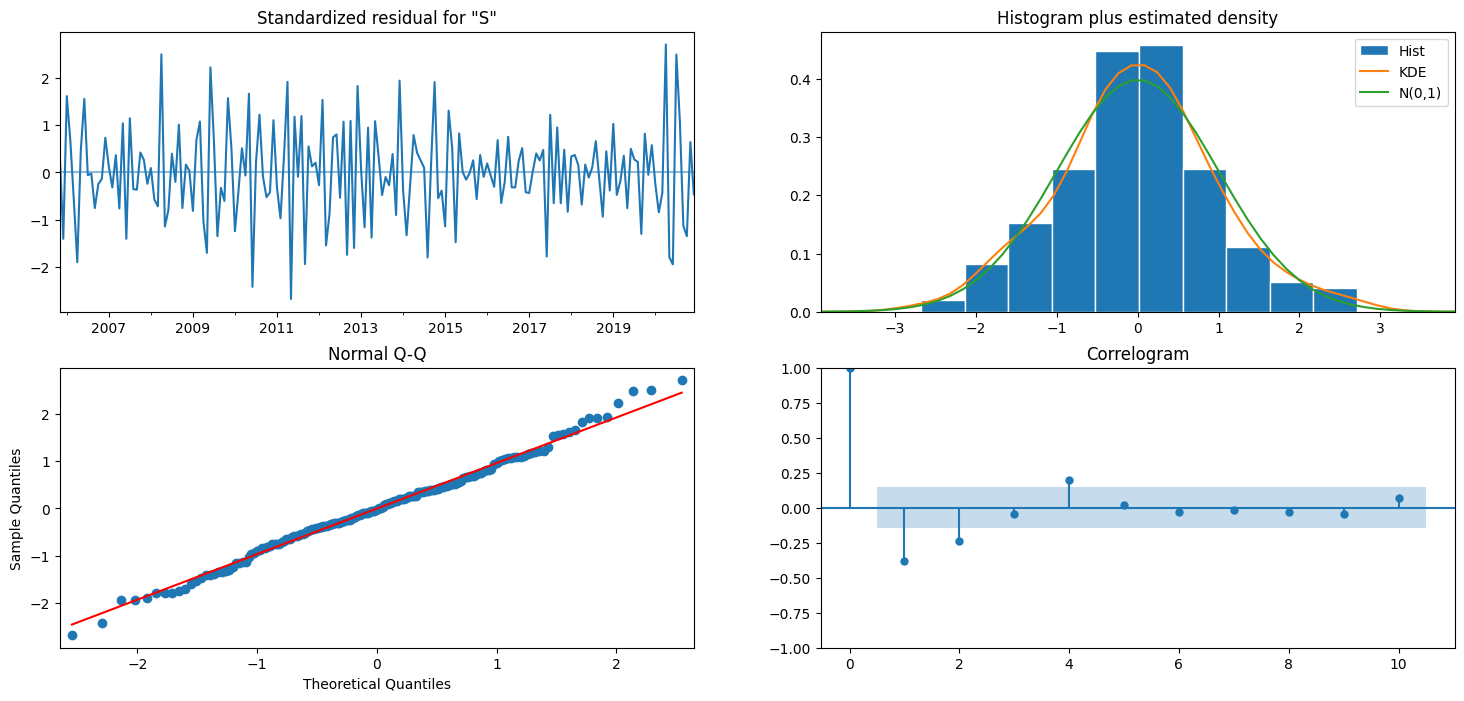

In [ ]:
resultado_m11116.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1216=",resultado_m11116.aic)
#print("Modelo 313=",resultado_m313.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1216=",resultado_m11116.bic)
#print("Modelo 313=",resultado_m313.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1216= 461.431999549161
Resultados de BIC (Bayesian information criterion)
Modelo 1216= 528.7161399777737


In [ ]:
dfTestConsumo.index[0]

Timestamp('2021-01-01 00:00:00')

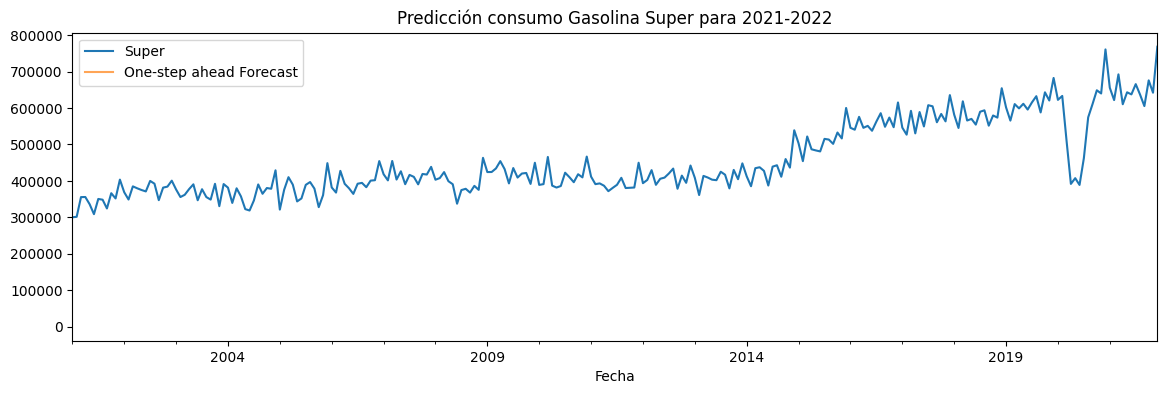

In [ ]:
dfTestSuper = dfTestConsumo['Super']
ImpSup = dfGeneralConsumo[['Super']].copy()
pred = resultado_m11116.get_prediction(start=dfTestSuper.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = ImpSup['2001-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
plt.title("Predicción consumo Gasolina Super para 2021-2022")
plt.legend()
plt.show()

pred

### Consumo regular 

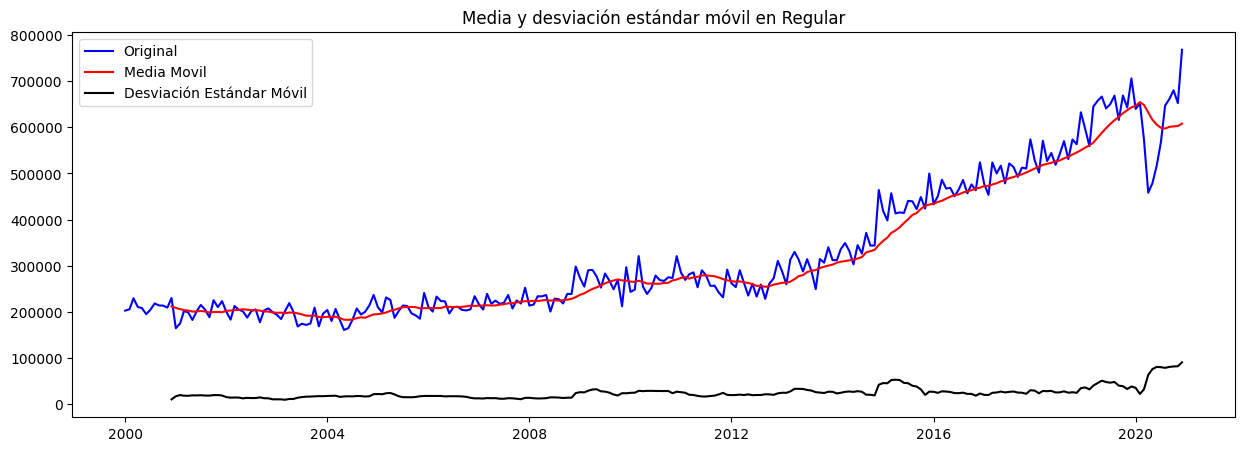

In [ ]:
# Se calcula la media móvil y la desviación estandar móvil.
mediaMovil = regularC.rolling(window=12).mean()
deMovil = regularC.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(regularC, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil en Regular')
plt.rcParams["figure.figsize"] = (10,4)
plt.show(block=False)

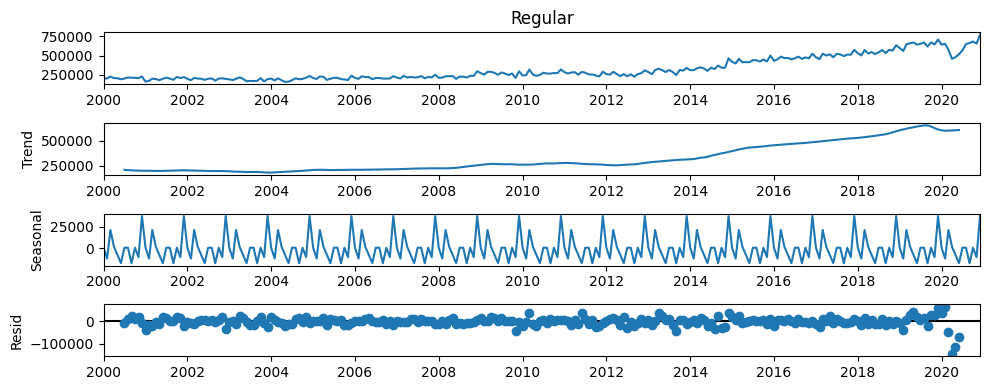

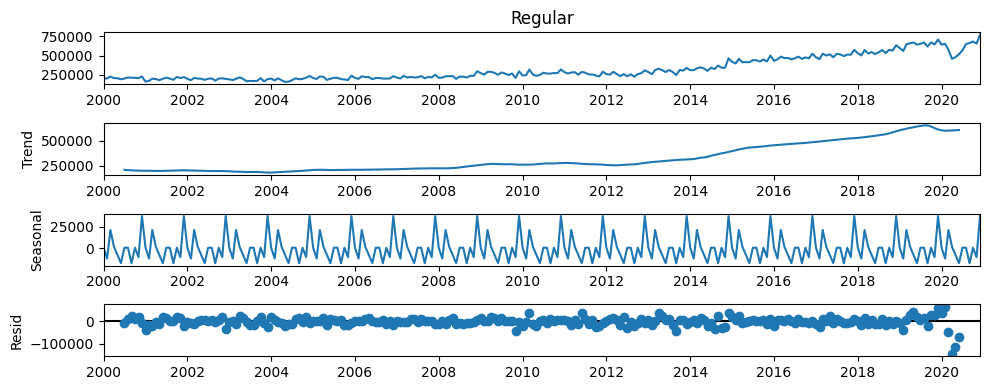

In [ ]:
descomposicion = seasonal_decompose(regularC)
descomposicion.plot()

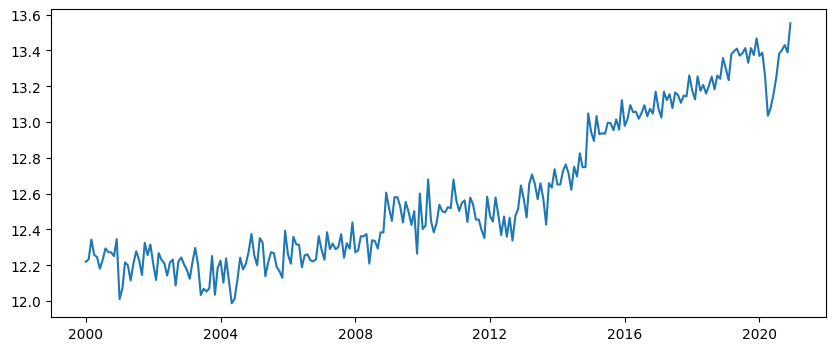

In [ ]:
RegularC_log = np.log(regularC)
plt.plot(RegularC_log)

In [ ]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(regularC, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.074049
p-value                        0.998762
# de retardos usados          13.000000
# de observaciones usadas    238.000000
Critical Value (1%)           -3.458128
Critical Value (5%)           -2.873762
Critical Value (10%)          -2.573283
dtype: float64


In [ ]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
regularC_diff = regularC.diff()
regularC_diff.dropna(inplace=True)
dfTest = adfuller(regularC_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -5.350912
p-value                        0.000004
# de retardos usados          12.000000
# de observaciones usadas    238.000000
Critical Value (1%)           -3.458128
Critical Value (5%)           -2.873762
Critical Value (10%)          -2.573283
dtype: float64


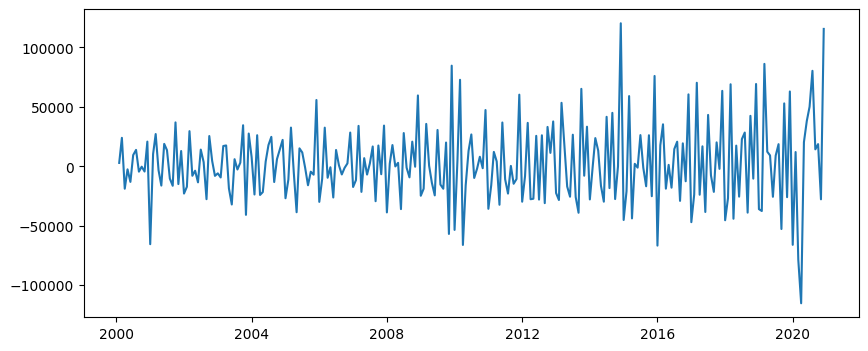

In [ ]:
plt.plot(regularC_diff)

In [ ]:
regularClog_diff = RegularC_log.diff()
regularClog_diff.dropna(inplace = True)
tsa_acf = acf(regularClog_diff,nlags=5,fft=False)
tsa_pacf = pacf(regularClog_diff, nlags=36)
tsa_acf

array([ 1.        , -0.39992638, -0.12891097,  0.13271486, -0.05749921,
        0.14438471])

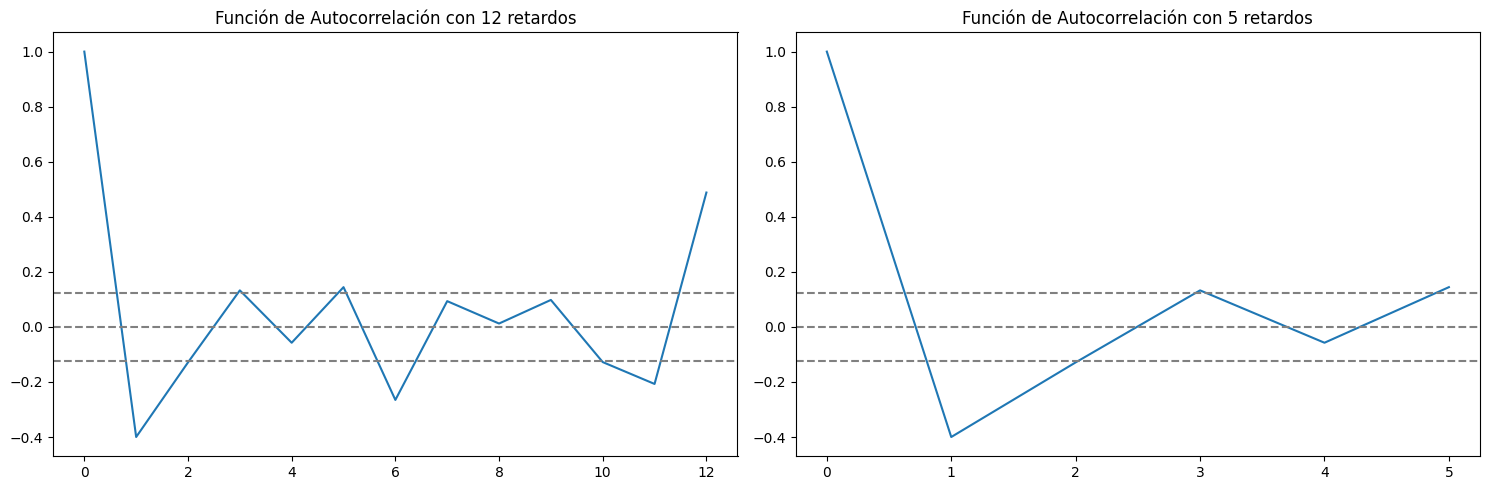

In [ ]:
#plot PAC
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(regularClog_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(regularClog_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

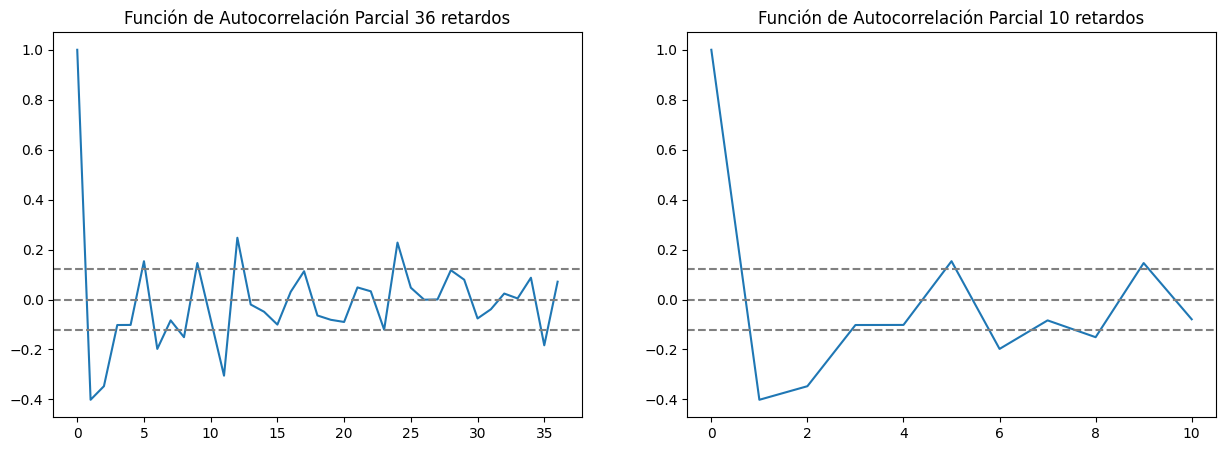

In [ ]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(regularClog_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(regularClog_diff, nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 10 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Con los gráficos dados, podemos observar que tenemos un valor p=11 q=1 & d=1. 

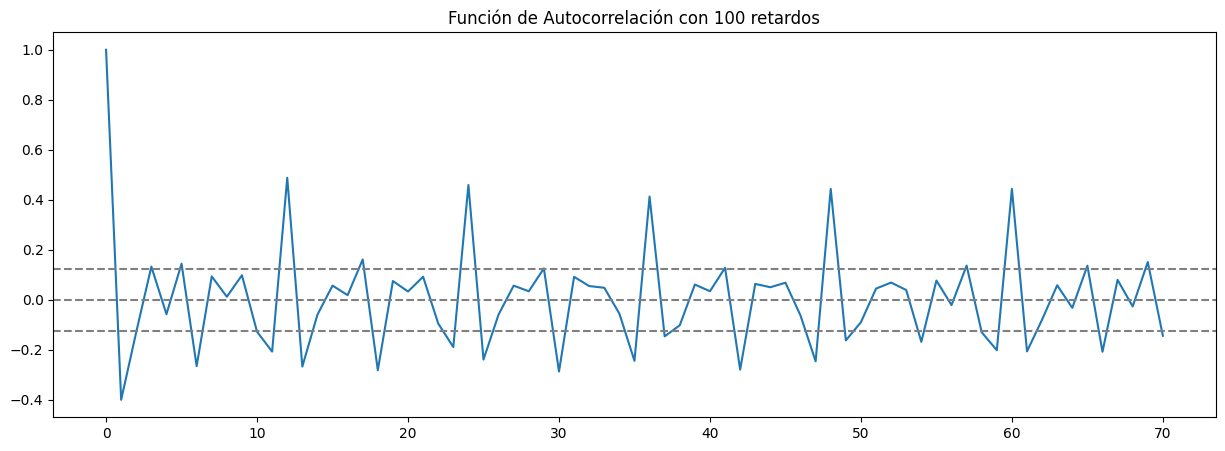

In [ ]:
plt.plot(acf(regularClog_diff,nlags=70,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 100 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 

In [ ]:
regularC_log_D = RegularC_log.diff(12)
regularC_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

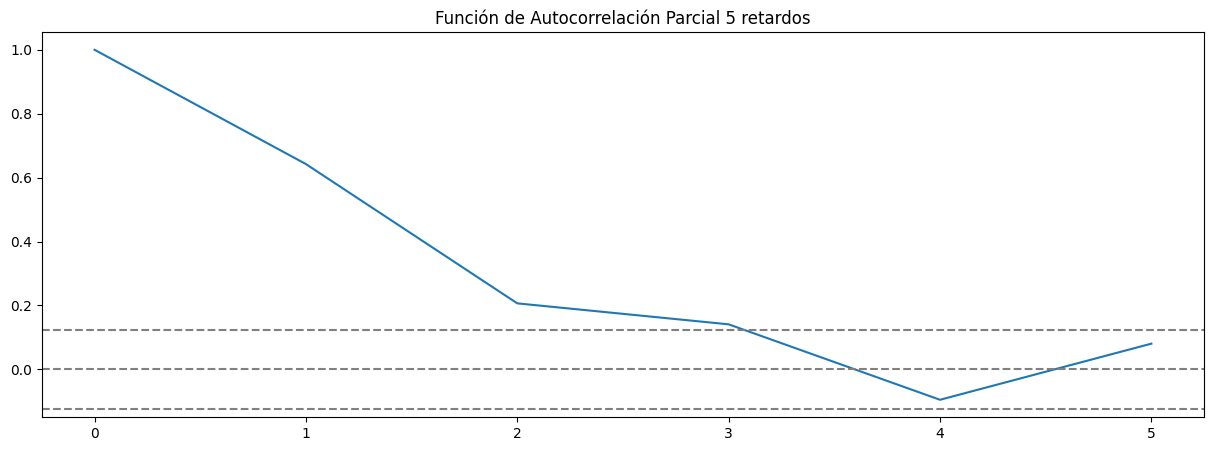

In [ ]:
plt.plot(pacf(regularC_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(regularClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

In [ ]:
modelo1111 = SARIMAX(SuperC_log, order=(11,1,1), seasonal_order=(3,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m1111 = modelo1111.fit()
print(resultado_m1111.summary().tables[1])

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04012D+00    |proj g|=  2.57387D+00

At iterate    5    f= -1.05302D+00    |proj g|=  9.68885D-02

At iterate   10    f= -1.06555D+00    |proj g|=  1.61822D+00

At iterate   15    f= -1.06963D+00    |proj g|=  4.21351D-01

At iterate   20    f= -1.07290D+00    |proj g|=  5.63436D-02

At iterate   25    f= -1.07573D+00    |proj g|=  1.89858D-01

At iterate   30    f= -1

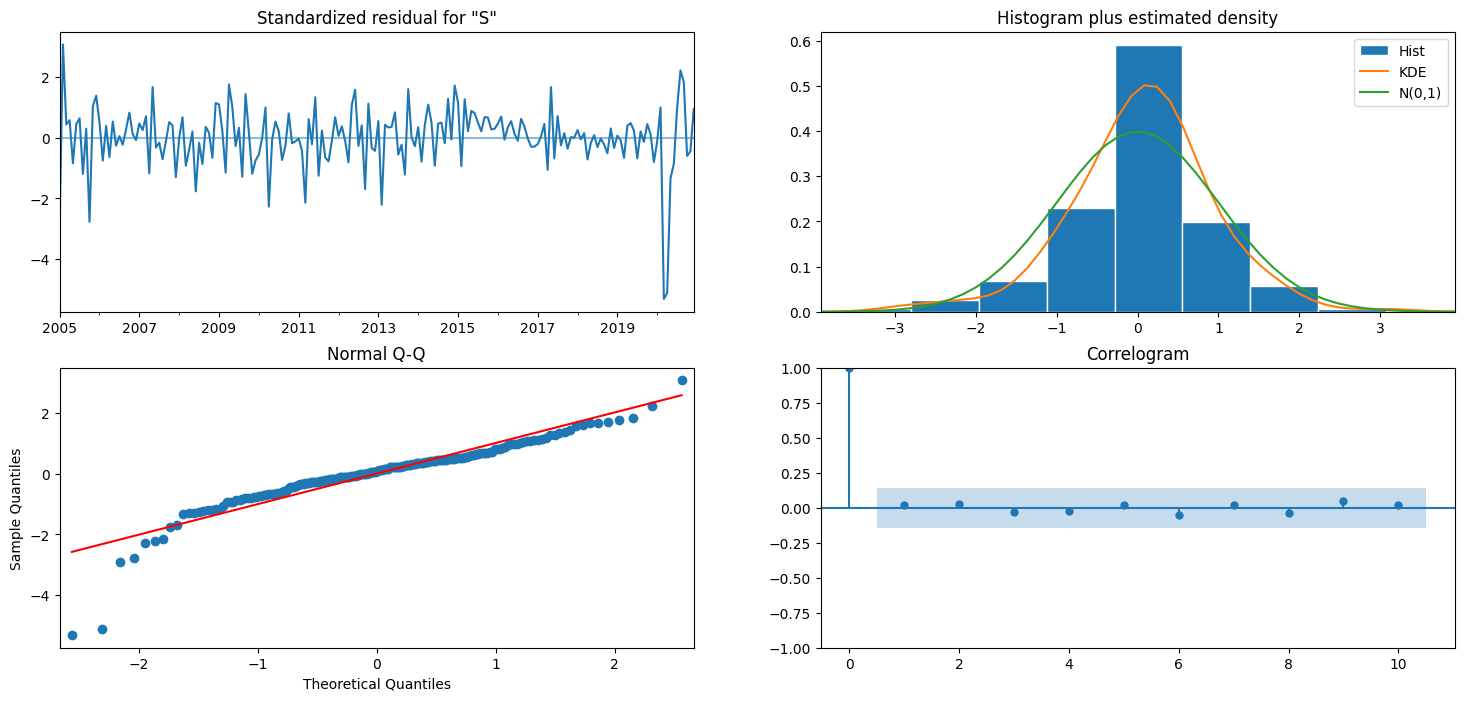

In [ ]:
resultado_m1111.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1111=",resultado_m1111.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1111=",resultado_m1111.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1111= -521.0062149957123
Resultados de BIC (Bayesian information criterion)
Modelo 1111= -465.62879367124003


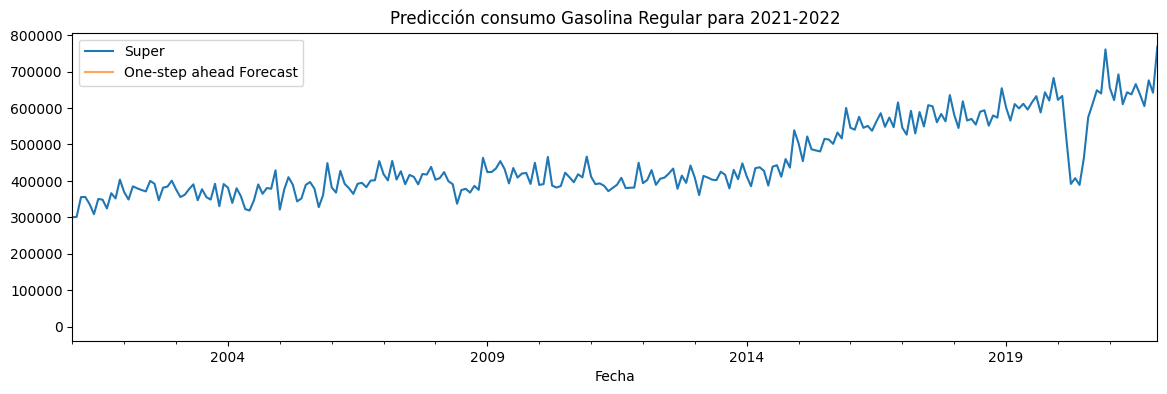

In [ ]:
dfTestRegular = dfTestConsumo['Regular']
ImpReg = dfGeneralConsumo[['Regular']].copy()
pred = resultado_m1111.get_prediction(start=dfTestRegular.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = ImpSup['2001-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
plt.title("Predicción consumo Gasolina Regular para 2021-2022")
plt.legend()
plt.show()

pred

## Consumo Diesel

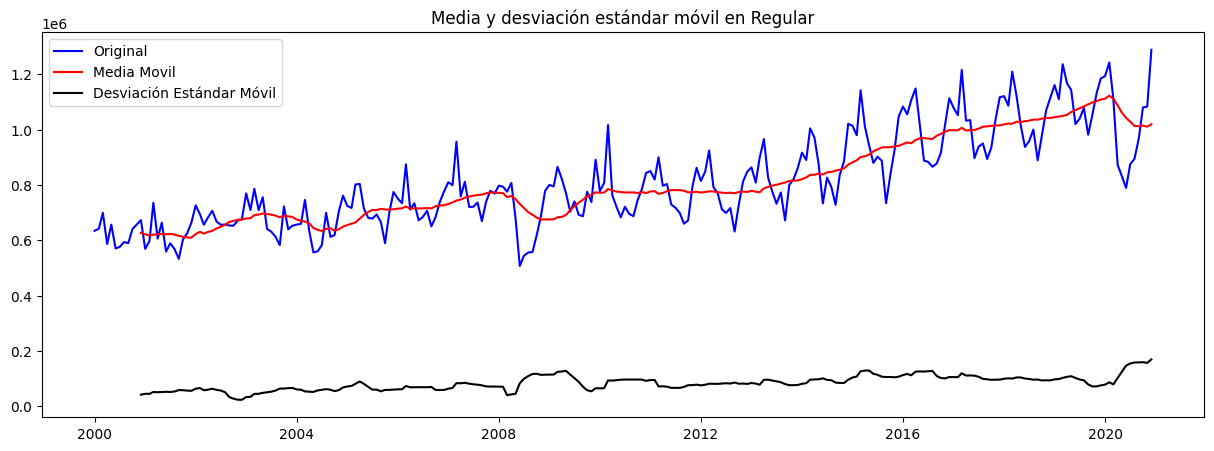

In [ ]:
# Se calcula la media móvil y la desviación estandar móvil.
mediaMovil = dieselC.rolling(window=12).mean()
deMovil = dieselC.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(dieselC, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil en Regular')
plt.rcParams["figure.figsize"] = (10,4)
plt.show(block=False)

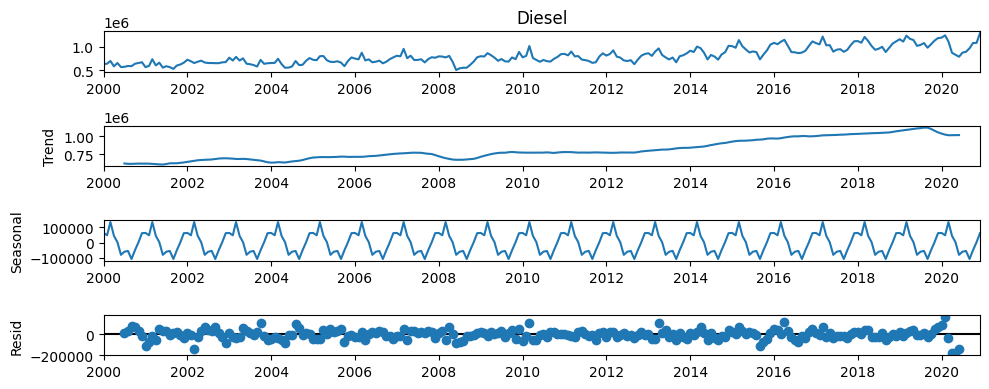

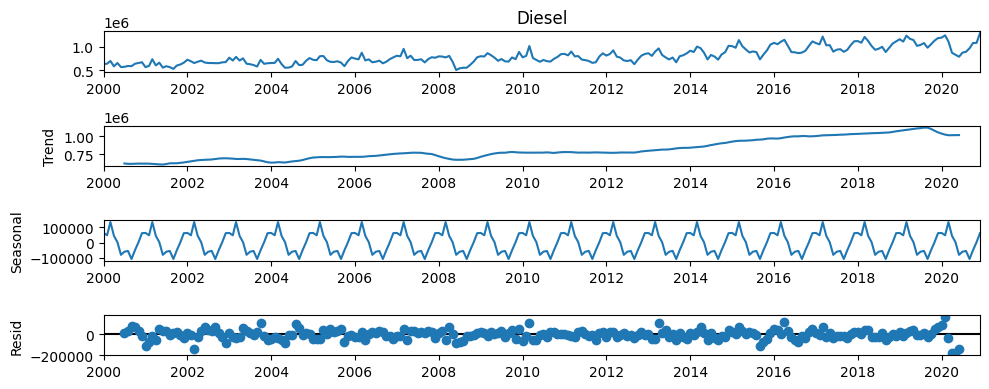

In [ ]:
descomposicion = seasonal_decompose(dieselC)
descomposicion.plot()

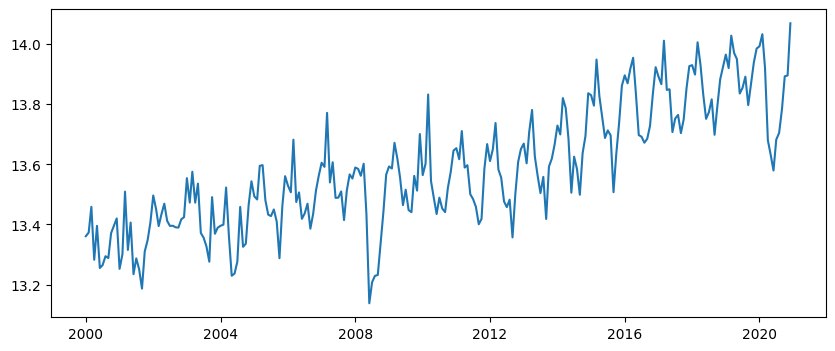

In [ ]:
DieselC_log = np.log(dieselC)
plt.plot(DieselC_log)

In [ ]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(dieselC, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.750665
p-value                        0.833186
# de retardos usados          12.000000
# de observaciones usadas    239.000000
Critical Value (1%)           -3.458011
Critical Value (5%)           -2.873710
Critical Value (10%)          -2.573256
dtype: float64


In [ ]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
dieselC_diff = dieselC.diff()
dieselC_diff.dropna(inplace=True)
dfTest = adfuller(dieselC_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -6.600923e+00
p-value                      6.739204e-09
# de retardos usados         1.100000e+01
# de observaciones usadas    2.390000e+02
Critical Value (1%)         -3.458011e+00
Critical Value (5%)         -2.873710e+00
Critical Value (10%)        -2.573256e+00
dtype: float64


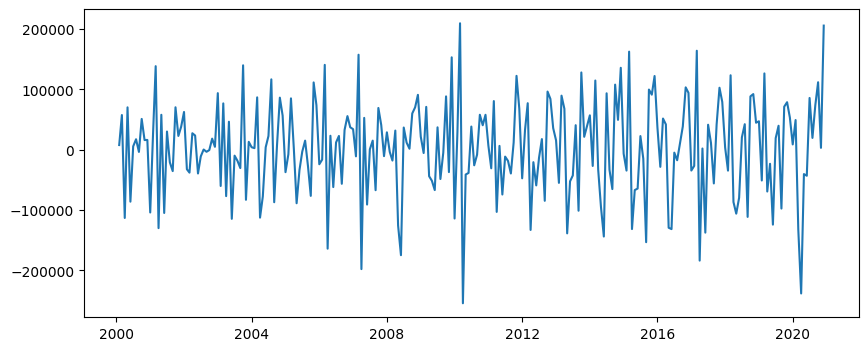

In [ ]:
plt.plot(dieselC_diff)

In [ ]:
dieselClog_diff = DieselC_log.diff()
dieselClog_diff.dropna(inplace = True)
tsa_acf = acf(dieselClog_diff,nlags=5,fft=False)
tsa_pacf = pacf(dieselClog_diff, nlags=36)
tsa_acf

array([ 1.        , -0.17281614,  0.02643323,  0.01830061, -0.08001887,
        0.01194164])

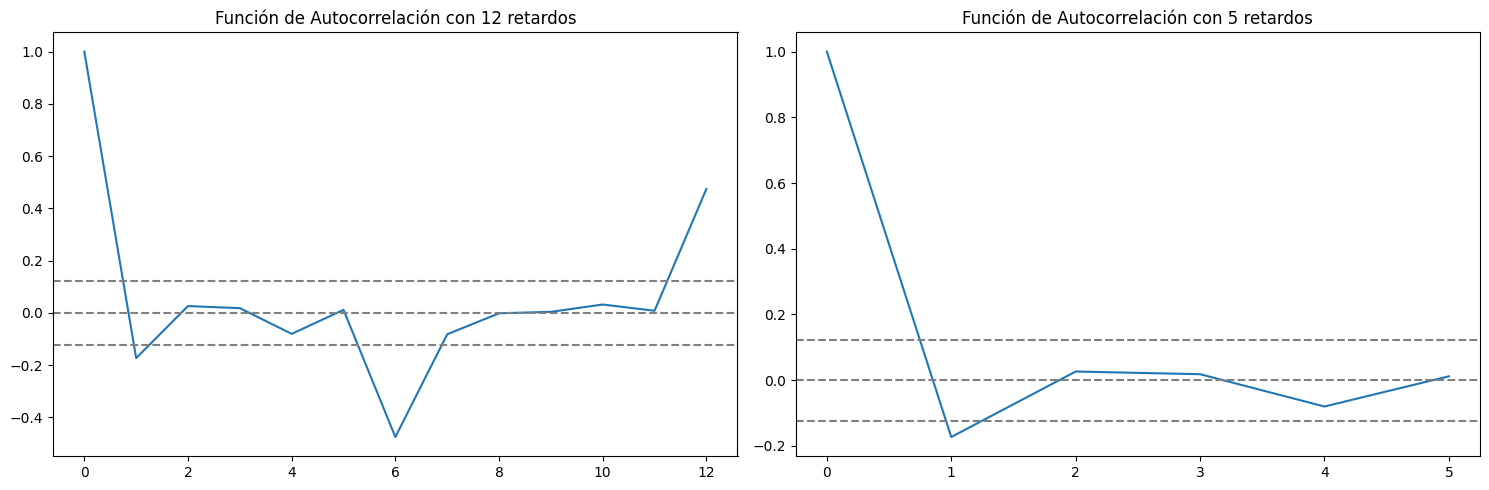

In [ ]:
#plot PAC
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(dieselClog_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(dieselClog_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

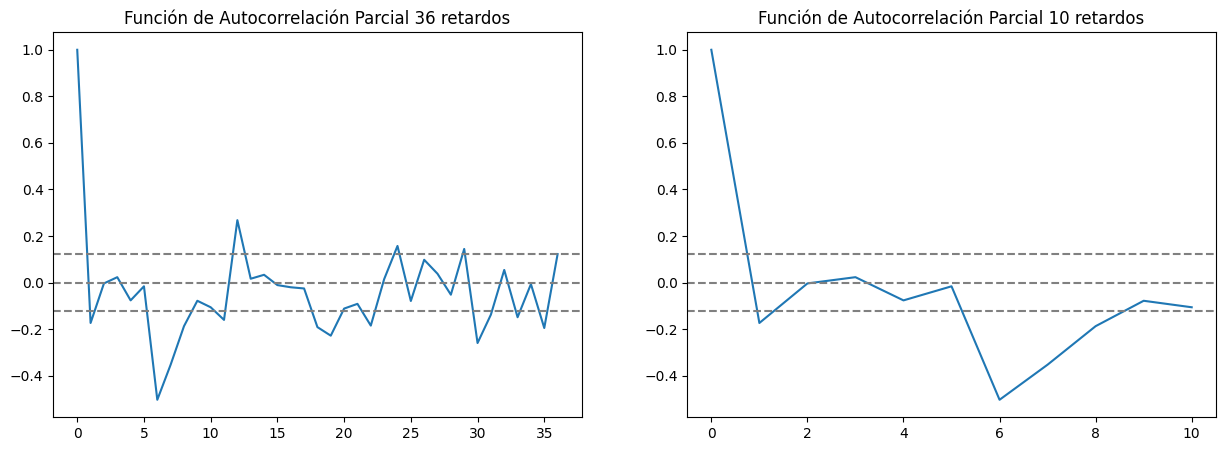

In [ ]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(dieselClog_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(dieselClog_diff, nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 10 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

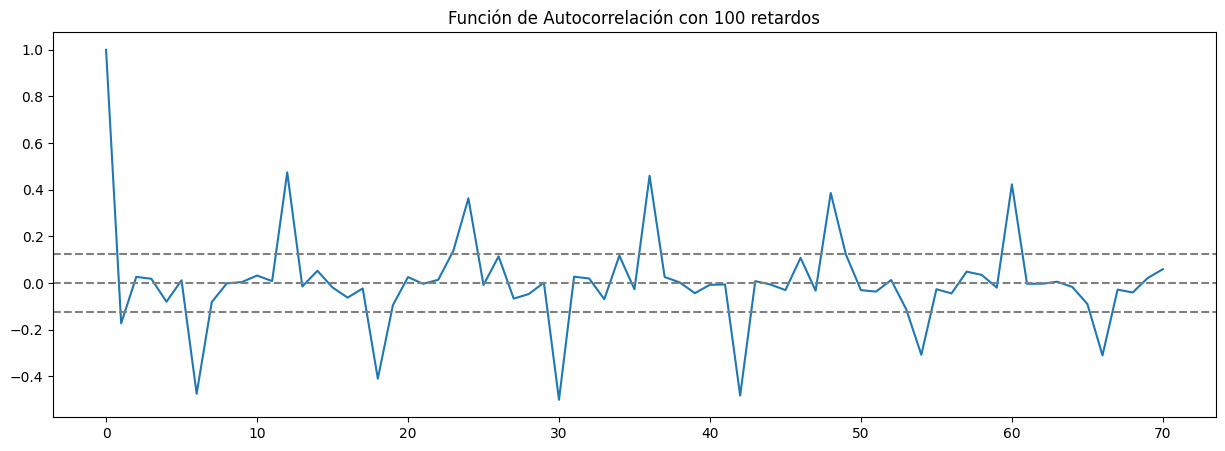

In [ ]:
plt.plot(acf(dieselClog_diff,nlags=70,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 100 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 

In [ ]:
dieselC_log_D = DieselC_log.diff(12)
dieselC_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

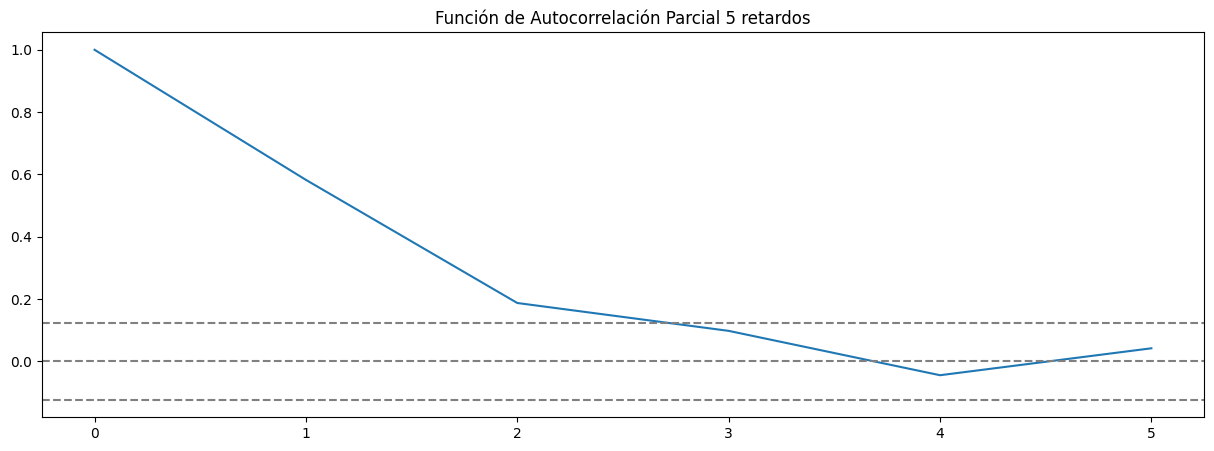

In [ ]:
plt.plot(pacf(dieselC_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dieselClog_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

In [ ]:
modelo1211 = SARIMAX(DieselC_log, order=(12,1,1), seasonal_order=(2,1,1,13), enforce_stationarity=False, enforce_invertibility=False)
resultado_m1211 = modelo1211.fit()
print(resultado_m1211.summary().tables[1])

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.04676D-01    |proj g|=  2.36908D+00

At iterate    5    f= -9.36580D-01    |proj g|=  9.16959D-01

At iterate   10    f= -9.43056D-01    |proj g|=  6.87948D-01

At iterate   15    f= -9.49678D-01    |proj g|=  1.22718D-01

At iterate   20    f= -9.50602D-01    |proj g|=  7.86937D-02

At iterate   25    f= -9.52606D-01    |proj g|=  1.48647D-02

At iterate   30    f= -9

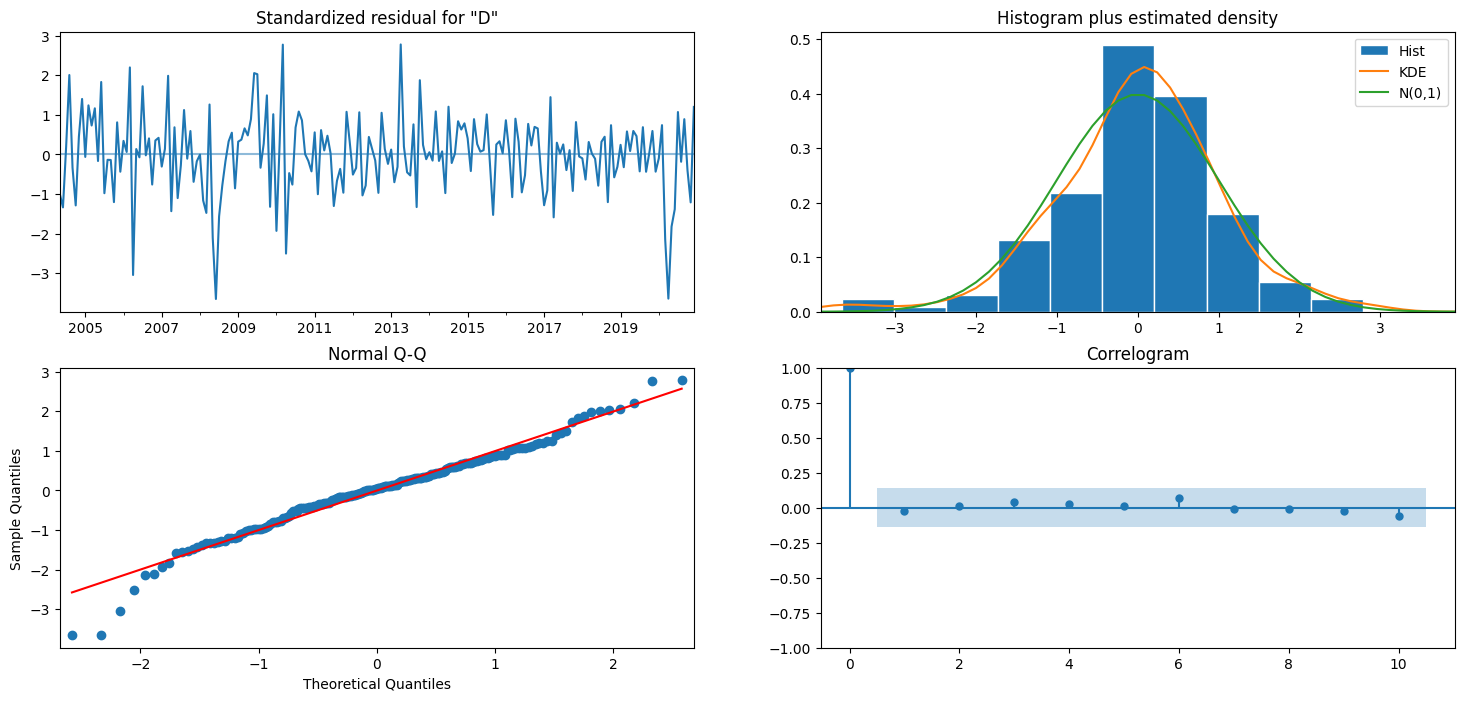

In [ ]:
resultado_m1211.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1111=",resultado_m1211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1111=",resultado_m1211.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1111= -452.6065877523183
Resultados de BIC (Bayesian information criterion)
Modelo 1111= -396.5351925210017


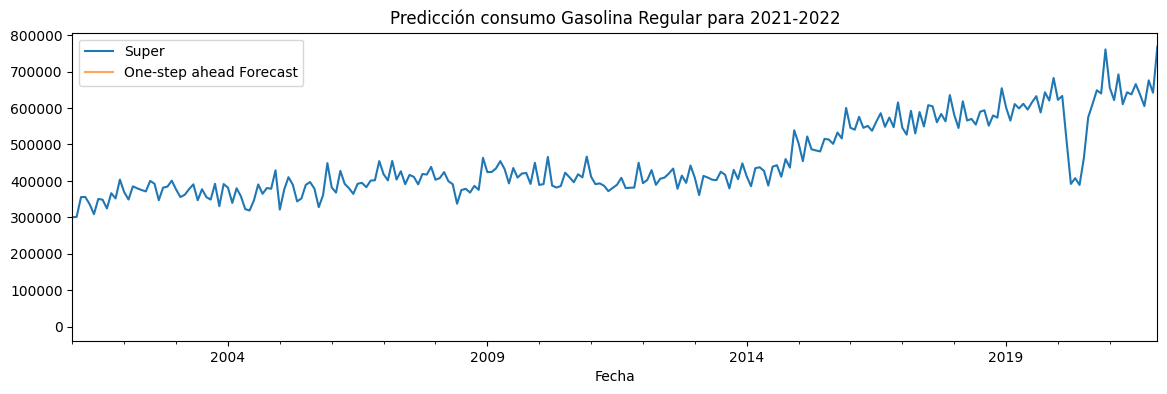

In [ ]:
dfTestDiesel = dfTestConsumo['Diesel']
ImpReg = dfGeneralConsumo[['Diesel']].copy()
pred = resultado_m1211.get_prediction(start=dfTestRegular.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = ImpSup['2001-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
plt.title("Predicción consumo Gasolina Regular para 2021-2022")
plt.legend()
plt.show()

pred

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32e457c4-31f9-4e67-9c0f-db9f6ef63e87' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>